In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
import xgboost as xgb
import cvxpy as cp
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

In [2]:
seed = 0

In [3]:
X, Y = data.load_german()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = X_train.Sex.values
A_test = X_test.Sex.values

## Model without fairness

Performing a search with Optuna, it will perform a 5-fold cross validation and select the parameters with the best mean score. The score used is the ROC.

In [4]:
model_search = OptunaSearchCV(
    models.XGBoostWrapper(min_child_weight=0),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=100,
    random_state = seed,
    verbose = 0,
)
model_search.fit(X_train, Y_train);


/tmp/ipykernel_2801/4227150075.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search = OptunaSearchCV(
[I 2023-11-08 10:42:06,366] A new study created in memory with name: no-name-95075761-389a-4ecd-8160-7664db46deae


[I 2023-11-08 10:42:06,578] Trial 0 finished with value: 0.7502334126218055 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.7502334126218055.
[I 2023-11-08 10:42:06,709] Trial 1 finished with value: 0.749655411150947 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.7502334126218055.
[I 2023-11-08 10:42:06,775] Trial 2 finished with value: 0.5663926043390328 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 0 with value: 0.7502334126218055.
[I 2023-11-08 10:42:06,897] Trial 3 finished with value: 0.7568468181191396 and parameters: {'n_estimators': 20, 'eta': 0.

KeyboardInterrupt: 

In [11]:
utils.eval_model_train_test(
    model_search,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.913257,0.866337,0.133663,0.364298,0.657037,0.850534,0.921053,train_g0
1,0.903525,0.831169,0.168831,0.415325,0.657037,0.831933,0.901408,train_g1
2,0.750558,0.747368,0.252632,0.494535,0.657037,0.726562,0.865854,test_g0
3,0.755745,0.808511,0.191489,0.548385,0.657037,0.722222,0.775510,test_g1


In [12]:
best_params = model_search.best_params_
best_params

{'n_estimators': 47,
 'eta': 0.2832661171775745,
 'max_leaves': 17,
 'colsample_bytree': 0.5567972215094216,
 'max_depth': 9,
 'l2_weight': 32.30950456746433}

## Model with dual step

### Experiment 1

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize ROC. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [26]:
model_search_fair = OptunaSearchCV(
    models.XGBoostWrapper(
        min_child_weight=0, 
        alpha = 1,
        sensitive_idx = 0,
        objective = models.penalize_max_loss_subgroups(0, 1)),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=25,
    random_state = seed,
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_2801/3639426879.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-08 11:30:14,580] A new study created in memory with name: no-name-48441122-8415-41f5-9b4c-e896141871b3
[I 2023-11-08 11:30:20,145] Trial 0 finished with value: 0.7465775964101857 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.7465775964101857.
[I 2023-11-08 11:30:21,666] Trial 1 finished with value: 0.7437031738371024 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.7465775964101857.
[I 2023-11-08 11:30:22,111] Trial 2 finished with value: 0.5865723823313108 and parameters: {'n_estimators'

In [27]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'n_estimators': 38,
 'eta': 0.21827256825273209,
 'max_leaves': 20,
 'colsample_bytree': 0.5262067349370807,
 'max_depth': 7,
 'l2_weight': 10.769210275662147}

In [28]:
lambda_values = np.append([0],np.logspace(-3, 2, num=24))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XGBoostWrapper(
        alpha=1,
        sensitive_idx = 0,
        min_child_weight = 0,
        objective = models.penalize_max_loss_subgroups(0, lambda_value),
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


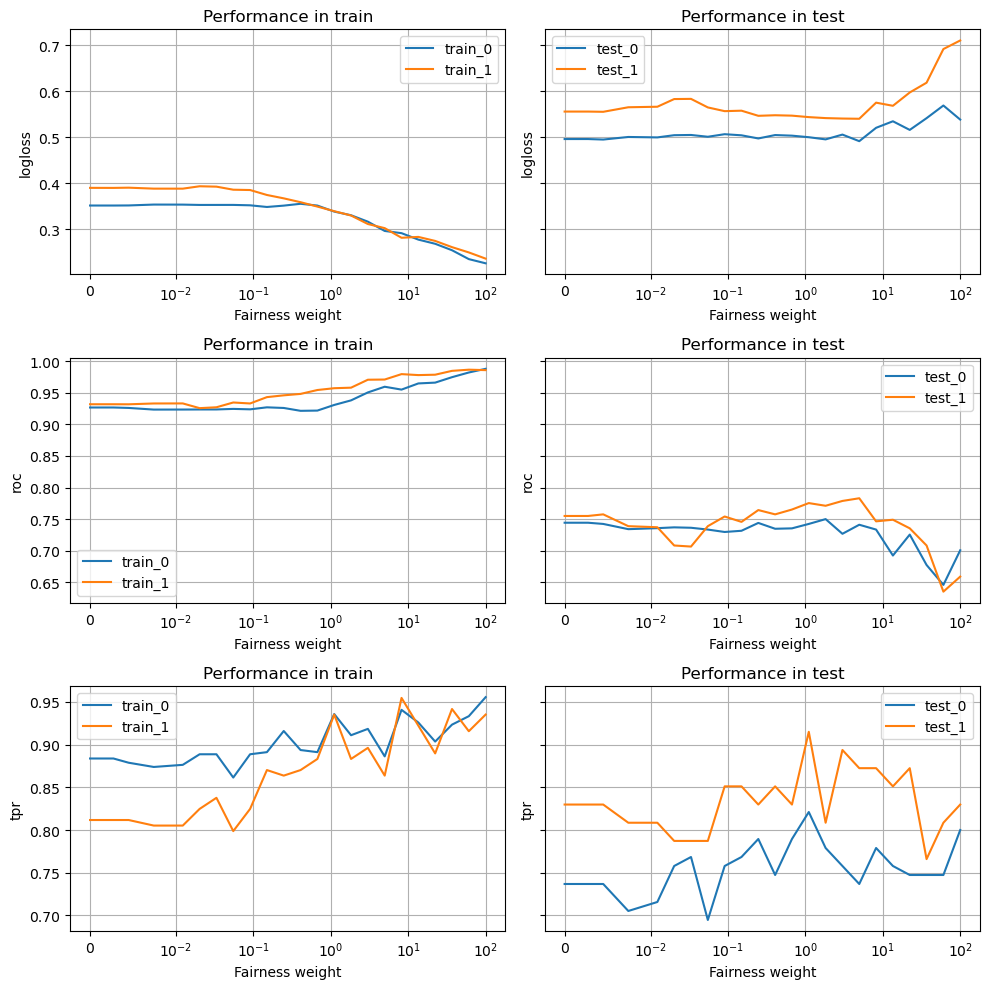

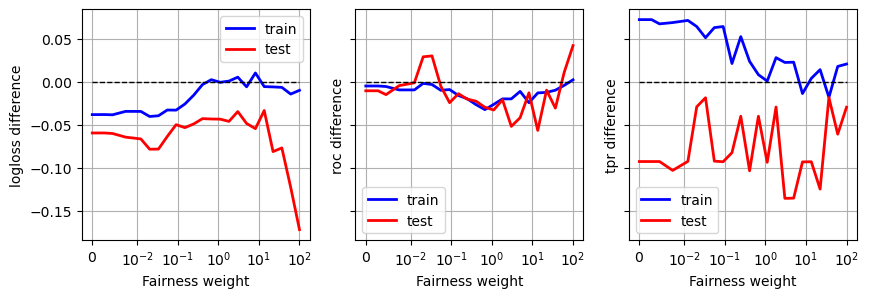

In [33]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 2

- Test different values of fairness weight, and for each, optimize the other parameters to maximize ROC.

In [34]:
lambda_values = np.append([0],np.logspace(-2, 3, num=20))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = OptunaSearchCV(
        models.XGBoostWrapper(
            min_child_weight = 0,
            alpha = 1,
            sensitive_idx = 0,
            objective = models.penalize_max_loss_subgroups(0, lambda_value)
        ),
        {
            "n_estimators" : IntDistribution(5, 50, step=3),
            "eta" : FloatDistribution(0.01, 0.5),
            "max_leaves" : IntDistribution(2, 50), 
            "colsample_bytree" : FloatDistribution(0.1, 1),
            "max_depth" : IntDistribution(3, 10),
            "l2_weight" : FloatDistribution(0.01, 100),
        },
        n_trials=20,
        random_state = seed,
        verbose = 0,
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_2801/4287469222.py:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dual_model_ = OptunaSearchCV(
[I 2023-11-08 11:37:03,621] A new study created in memory with name: no-name-e7bac24f-aa3f-472d-8f7b-d18d23512446
[I 2023-11-08 11:37:04,049] Trial 0 finished with value: 0.7502334126218055 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.7502334126218055.
[I 2023-11-08 11:37:05,333] Trial 1 finished with value: 0.749655411150947 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.7502334126218055.
[I 2023-11-08 11:37:06,309] Trial 2 finished with value: 0.5663926043390328 

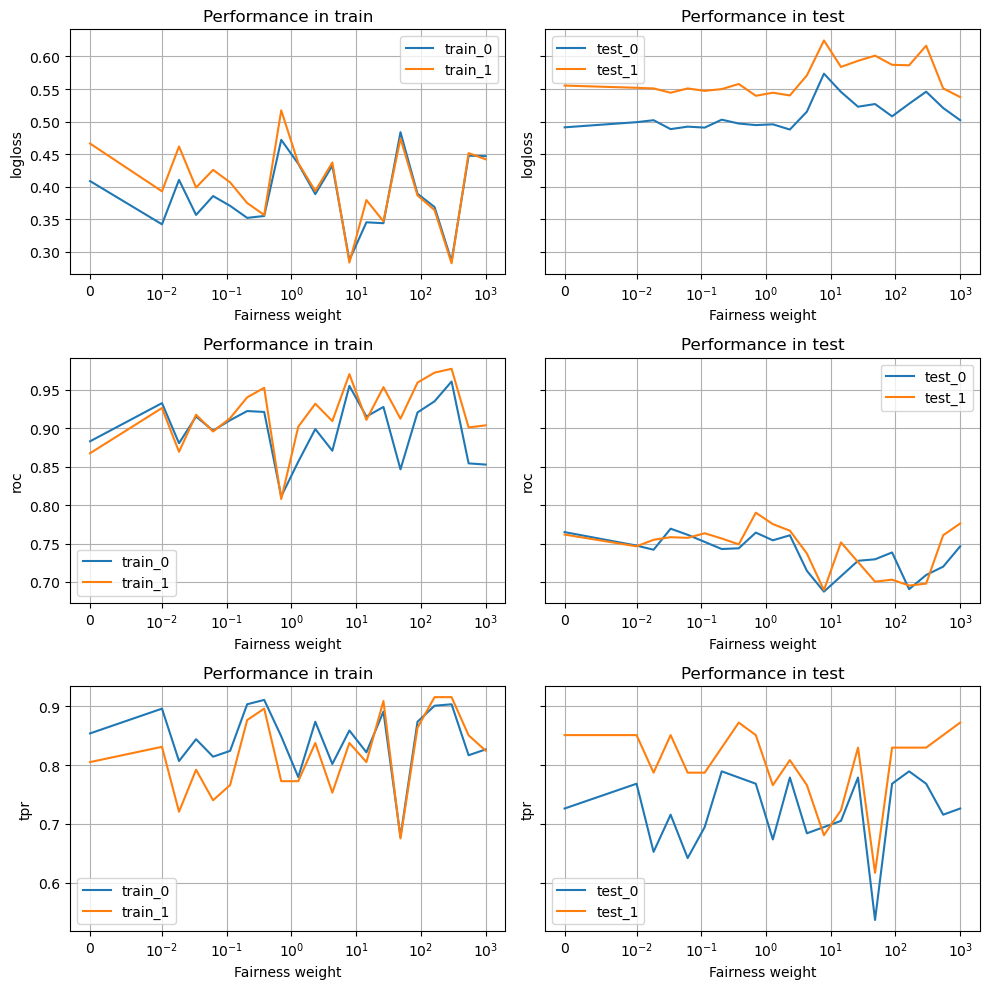

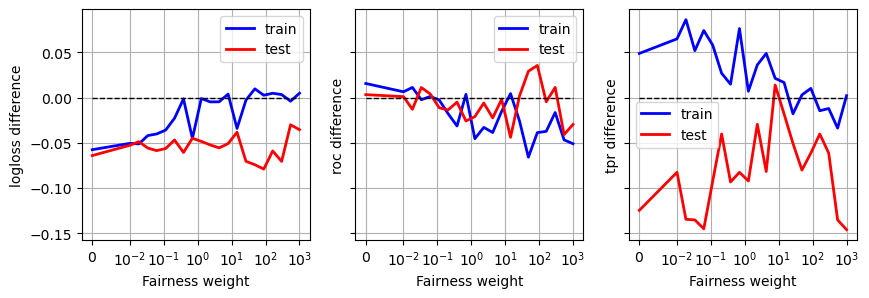

In [35]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 3

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize an weighted sum of ROC and EOD. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [36]:
model_search_fair = OptunaSearchCV(
    models.XGBoostWrapper(
        min_child_weight=0, 
        alpha = 0.5,
        sensitive_idx = 0,
        objective = models.penalize_max_loss_subgroups(0, 1)),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=25,
    random_state = seed,
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_2801/206683885.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-08 11:51:40,498] A new study created in memory with name: no-name-953177ed-96cb-41f9-8b1f-6507e4b8ad61
[I 2023-11-08 11:51:42,854] Trial 0 finished with value: 0.8505946634928737 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.8505946634928737.
[I 2023-11-08 11:51:43,797] Trial 1 finished with value: 0.8453374262854642 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.8505946634928737.
[I 2023-11-08 11:51:44,460] Trial 2 finished with value: 0.7892401384713347 and parameters: {'n_estimators':

In [37]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'n_estimators': 23,
 'eta': 0.0746412174169461,
 'max_leaves': 34,
 'colsample_bytree': 0.24776136657853376,
 'max_depth': 8,
 'l2_weight': 84.8426705275996}

In [38]:
utils.eval_model_train_test(
    model_search_fair,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.782288,0.678218,0.321782,0.569051,0.64235,0.699288,0.875399,train_g0
1,0.791473,0.649351,0.350649,0.604095,0.64235,0.697479,0.847458,train_g1
2,0.726635,0.568421,0.431579,0.573255,0.64235,0.617188,0.870968,test_g0
3,0.727234,0.702128,0.297872,0.614199,0.64235,0.680556,0.785714,test_g1


In [39]:
lambda_values = np.append([0],np.logspace(-3, 2, num=24))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XGBoostWrapper(
        alpha=0.5,
        sensitive_idx = 0,
        min_child_weight = 0,
        objective = models.penalize_max_loss_subgroups(0, lambda_value),
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


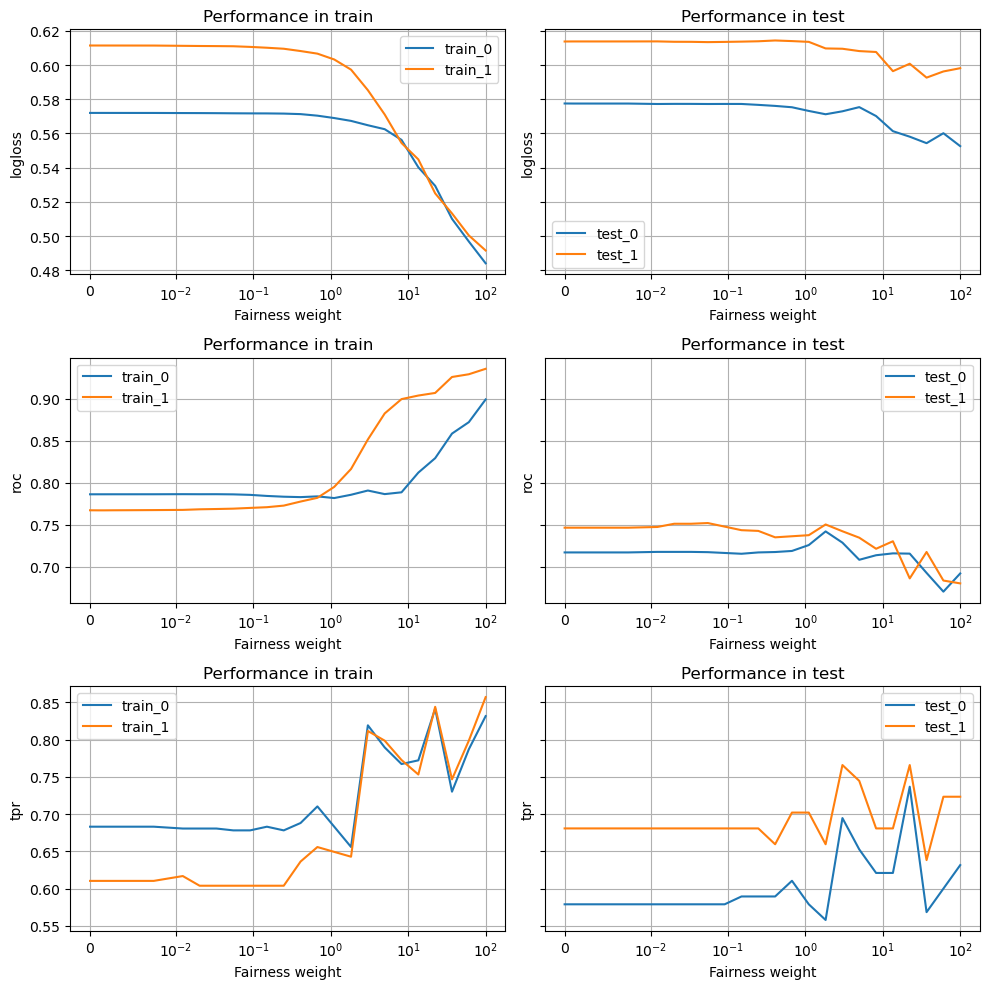

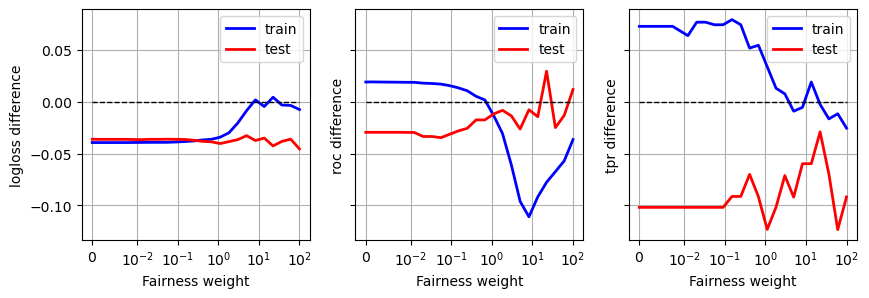

In [40]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 4

In [41]:
lambda_values = np.append([0],np.logspace(-2, 3, num=10))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = OptunaSearchCV(
        models.XGBoostWrapper(
            min_child_weight = 0,
            alpha = 0.5,
            sensitive_idx = 0,
            objective = models.penalize_max_loss_subgroups(0, lambda_value)
        ),
        {
            "n_estimators" : IntDistribution(5, 50, step=3),
            "eta" : FloatDistribution(0.01, 0.5),
            "max_leaves" : IntDistribution(2, 50), 
            "colsample_bytree" : FloatDistribution(0.1, 1),
            "max_depth" : IntDistribution(3, 10),
            "l2_weight" : FloatDistribution(0.01, 100),
        },
        n_trials=25,
        random_state = seed,
        verbose = 0,
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_2801/2360389392.py:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dual_model_ = OptunaSearchCV(
[I 2023-11-08 11:53:27,932] A new study created in memory with name: no-name-08912563-9234-44a6-9043-73dd0b994afc


[I 2023-11-08 11:53:29,695] Trial 0 finished with value: 0.8558931116453754 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.8558931116453754.
[I 2023-11-08 11:53:30,213] Trial 1 finished with value: 0.8544209825530125 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.8558931116453754.
[I 2023-11-08 11:53:30,359] Trial 2 finished with value: 0.7797509391247777 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 0 with value: 0.8558931116453754.
[I 2023-11-08 11:53:31,165] Trial 3 finished with value: 0.8425719543247675 and parameters: {'n_estimators': 20, 'eta': 0

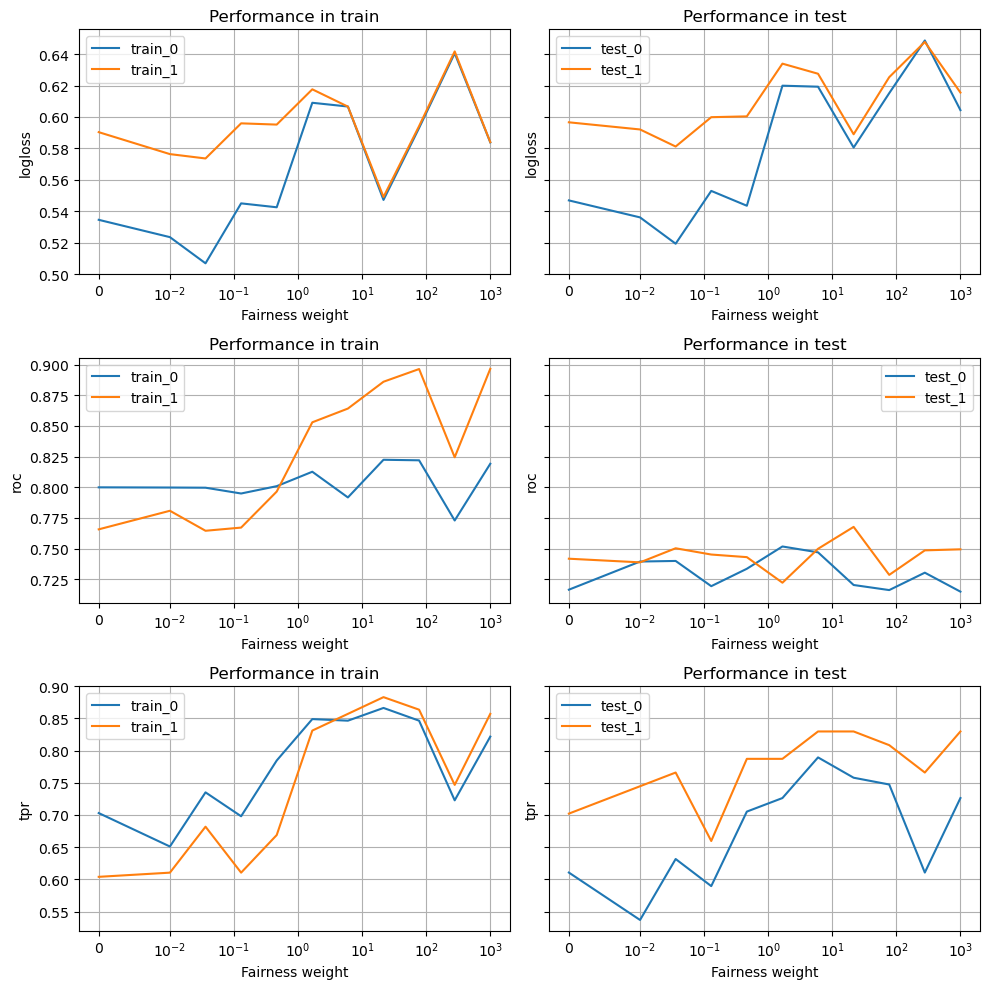

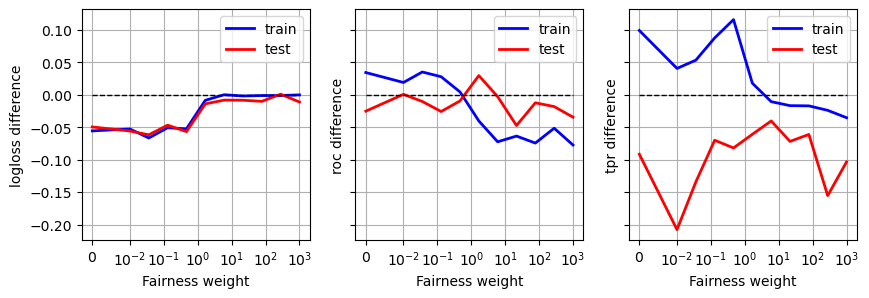

In [42]:
utils.comparison_subgrous_metrics_lambda(results)